Target Construction

In [1]:
import os
import csv

# ========= PATH CONFIG =========
INPUT_CSV = "/content/drive/MyDrive/PR_Sky/SASS/Data/airline.csv"
OUT_DIR   = "/content/drive/MyDrive/PR_Sky/SASS/Data/Airline_Dataset_work_SASS"
os.makedirs(OUT_DIR, exist_ok=True)

OUTPUT_CSV = os.path.join(OUT_DIR, "airline_with_target.csv")

TARGET_COL = "satisfaction_class"

# ========= LOAD & DETECT RATING COLUMN =========
with open(INPUT_CSV, "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    header = reader.fieldnames
    if header is None:
        raise ValueError("No header found in airline.csv!")

    # Try to detect rating column name
    rating_candidates = ["overall_rating", "overall", "rating"]
    rating_col = None
    for c in rating_candidates:
        if c in header:
            rating_col = c
            break

    if rating_col is None:
        raise ValueError(
            f"Could not find a rating column in airline.csv. "
            f"Tried: {rating_candidates}. Available columns: {header}"
        )

    print("Using rating column:", rating_col)

    # Read all rows now that we know the rating column
    f.seek(0)
    reader = csv.DictReader(f)
    rows_raw = [row for row in reader]

# ========= TARGET CONSTRUCTION =========
rows = []
for row in rows_raw:
    rating_raw = row.get(rating_col, "").strip()
    if rating_raw == "":
        # skip rows with missing rating
        continue

    try:
        rating_val = float(rating_raw)
    except ValueError:
        # skip rows with non-numeric rating
        continue

    # ----- Map rating to satisfaction_class -----
    # 0 → Negative (1–4)
    # 1 → Neutral  (5–7)
    # 2 → Positive (8–10)
    if rating_val <= 4:
        sc = 0
    elif rating_val <= 7:
        sc = 1
    else:
        sc = 2

    row[rating_col] = rating_val      # numeric rating
    row[TARGET_COL] = sc              # new target
    rows.append(row)

# Ensure target column is in header
if TARGET_COL not in header:
    header = header + [TARGET_COL]

# ========= SAVE OUTPUT CSV =========
with open(OUTPUT_CSV, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=header)
    writer.writeheader()
    for r in rows:
        writer.writerow(r)

# ========= PRINT STATS =========
row_count = len(rows)
col_count = len(header)
print("Final dataset shape:", (row_count, col_count))
print("Saved file at:", OUTPUT_CSV)

# Class distribution
c0 = c1 = c2 = 0
for r in rows:
    sc = r[TARGET_COL]
    if sc == 0:
        c0 += 1
    elif sc == 1:
        c1 += 1
    elif sc == 2:
        c2 += 1

total = c0 + c1 + c2
if total == 0:
    print("No valid rows after filtering!")
else:
    p0 = c0 / total
    p1 = c1 / total
    p2 = c2 / total

    print("\nClass distribution (counts):")
    print("  0 (Negative):", c0)
    print("  1 (Neutral) :", c1)
    print("  2 (Positive):", c2)

    print("\nClass distribution (proportions):")
    print("  0 (Negative):", round(p0, 3))
    print("  1 (Neutral) :", round(p1, 3))
    print("  2 (Positive):", round(p2, 3))


Using rating column: overall_rating
Final dataset shape: (36861, 21)
Saved file at: /content/drive/MyDrive/PR_Sky/SASS/Data/Airline_Dataset_work_SASS/airline_with_target.csv

Class distribution (counts):
  0 (Negative): 12571
  1 (Neutral) : 7688
  2 (Positive): 16602

Class distribution (proportions):
  0 (Negative): 0.341
  1 (Neutral) : 0.209
  2 (Positive): 0.45


Numeric Features (for GNB)

In [2]:
import os
import csv
import random

# ================== PATHS ==================
BASE_DIR   = "/content/drive/MyDrive/PR_Sky/SASS/Data/Airline_Dataset_work_SASS"
INPUT_CSV  = os.path.join(BASE_DIR, "airline_with_target.csv")

OUT_TRAIN  = os.path.join(BASE_DIR, "airline_train_proc.csv")
OUT_TEST   = os.path.join(BASE_DIR, "airline_test_proc.csv")

os.makedirs(BASE_DIR, exist_ok=True)

TARGET_COL = "satisfaction_class"

# ================== LOAD DATA ==================
rows = []
with open(INPUT_CSV, "r", encoding="utf-8") as f:
    r = csv.DictReader(f)
    header = r.fieldnames
    for row in r:
        rows.append(row)

if not rows:
    raise ValueError("No rows loaded from input CSV!")

print("Loaded shape:", (len(rows), len(header)))
print("Columns:", header)

if TARGET_COL not in header:
    raise ValueError(f"Target column '{TARGET_COL}' not found. Run Phase 1 first.")

# ================== CLEAN TARGET ==================
clean = []
for row in rows:
    v = row.get(TARGET_COL, "")
    ok = True
    try:
        v2 = float(v)
        if v2 == int(v2):
            v2 = int(v2)
        else:
            ok = False
    except:
        ok = False

    if ok and v2 in (0, 1, 2):
        row[TARGET_COL] = v2
        clean.append(row)

rows = clean
print("Rows after target cleaning:", len(rows))

# ================== AUTO-DETECT NUMERIC RATING FEATURES ==================
# Take ALL columns that end with "_rating" (including overall_rating),
# and are not the target column.
numeric_cols = [
    c for c in header
    if c.endswith("_rating") and c != TARGET_COL
]

if not numeric_cols:
    raise ValueError(
        "No numeric rating features found automatically. "
        "Check if your rating columns end with '_rating'."
    )

print("\nInitial numeric feature candidates found:", numeric_cols)

# ================== PARSE NUMERIC VALUES & CHECK MISSINGNESS ==================
n = len(rows)
missing_counts = {c: 0 for c in numeric_cols}

for row in rows:
    for c in numeric_cols:
        txt = row.get(c, "")
        try:
            val = float(txt)
            row[c] = val
        except:
            row[c] = None
            missing_counts[c] += 1

missing_info = []
for c in numeric_cols:
    miss_pct = missing_counts[c] / n if n > 0 else 0.0
    missing_info.append((c, miss_pct))

missing_info.sort(key=lambda t: t[1], reverse=True)

print("\nMissingness (numeric features):")
for c, pct in missing_info:
    print(f"  {c}: {pct:.3f}")

# Drop features with > 50% missing
features = [c for c, pct in missing_info if pct <= 0.5]

if not features:
    raise ValueError(
        "All numeric features have >50% missing values. "
        "Adjust threshold or inspect the data."
    )

print("\nSelected numeric features after dropping >50% missing:")
print(features)

# ================== CLASS DISTRIBUTION (OVERALL) ==================
c0 = c1 = c2 = 0
for row in rows:
    y = row[TARGET_COL]
    if y == 0:
        c0 += 1
    elif y == 1:
        c1 += 1
    elif y == 2:
        c2 += 1

total = c0 + c1 + c2
print("\nClass distribution (counts):")
print("  0:", c0)
print("  1:", c1)
print("  2:", c2)

if total > 0:
    print("\nClass distribution (proportions):")
    print("  0:", round(c0 / total, 3))
    print("  1:", round(c1 / total, 3))
    print("  2:", round(c2 / total, 3))
else:
    print("\nNo data to compute class distribution.")

# ================== STRATIFIED SPLIT (80/20) ==================
idx0, idx1, idx2 = [], [], []
for i, row in enumerate(rows):
    y = row[TARGET_COL]
    if y == 0:
        idx0.append(i)
    elif y == 1:
        idx1.append(i)
    elif y == 2:
        idx2.append(i)

random.seed(42)
random.shuffle(idx0)
random.shuffle(idx1)
random.shuffle(idx2)

def split_idx(lst, test_ratio=0.20):
    n = len(lst)
    n_test = int(n * test_ratio)
    te = lst[:n_test]
    tr = lst[n_test:]
    return tr, te

tr0, te0 = split_idx(idx0)
tr1, te1 = split_idx(idx1)
tr2, te2 = split_idx(idx2)

train_idx = tr0 + tr1 + tr2
test_idx  = te0 + te1 + te2

train_rows = [rows[i] for i in train_idx]
test_rows  = [rows[i] for i in test_idx]

print("\nStratified split sizes:")
print("  Train:", len(train_rows))
print("  Test :", len(test_rows))

# ================== MEDIAN IMPUTATION (TRAIN-BASED) ==================
medians = {}
for c in features:
    vals = []
    for row in train_rows:
        v = row.get(c, None)
        if v is not None:
            vals.append(v)
    vals.sort()
    if not vals:
        med = 0.0
    else:
        m = len(vals)
        mid = m // 2
        if m % 2 == 1:
            med = vals[mid]
        else:
            med = (vals[mid - 1] + vals[mid]) / 2.0
    medians[c] = med

print("\nFeature medians (computed from TRAIN only):")
for c in features:
    print(f"  {c}: {medians[c]}")

# Impute in TRAIN
for row in train_rows:
    for c in features:
        if row.get(c, None) is None:
            row[c] = medians[c]

# Impute in TEST using same medians
for row in test_rows:
    for c in features:
        if row.get(c, None) is None:
            row[c] = medians[c]

# ================== SAVE TRAIN / TEST CSVs ==================
out_header = features + [TARGET_COL]

with open(OUT_TRAIN, "w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=out_header)
    w.writeheader()
    for row in train_rows:
        out_row = {c: row.get(c, "") for c in out_header}
        w.writerow(out_row)

with open(OUT_TEST, "w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=out_header)
    w.writeheader()
    for row in test_rows:
        out_row = {c: row.get(c, "") for c in out_header}
        w.writerow(out_row)

print("\nSaved preprocessed numeric datasets:")
print("  Train:", OUT_TRAIN)
print("  Test :", OUT_TEST)

print("\nFinal shapes (numeric view):")
print("  X_train:", (len(train_rows), len(features)))
print("  X_test :", (len(test_rows), len(features)))


Loaded shape: (36861, 21)
Columns: ['airline_name', 'link', 'title', 'author', 'author_country', 'date', 'content', 'aircraft', 'type_traveller', 'cabin_flown', 'route', 'overall_rating', 'seat_comfort_rating', 'cabin_staff_rating', 'food_beverages_rating', 'inflight_entertainment_rating', 'ground_service_rating', 'wifi_connectivity_rating', 'value_money_rating', 'recommended', 'satisfaction_class']
Rows after target cleaning: 36861

Initial numeric feature candidates found: ['overall_rating', 'seat_comfort_rating', 'cabin_staff_rating', 'food_beverages_rating', 'inflight_entertainment_rating', 'ground_service_rating', 'wifi_connectivity_rating', 'value_money_rating']

Missingness (numeric features):
  wifi_connectivity_rating: 0.985
  ground_service_rating: 0.940
  inflight_entertainment_rating: 0.230
  food_beverages_rating: 0.180
  seat_comfort_rating: 0.168
  cabin_staff_rating: 0.168
  value_money_rating: 0.026
  overall_rating: 0.000

Selected numeric features after dropping >50%

Text Features for MNB

In [3]:
!pip install gensim scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 62.6 MB/s eta 0:00:00


In [6]:
import os
import csv
import re
import math
import random
import numpy as np

from gensim.models import Word2Vec
from sklearn.cluster import MiniBatchKMeans

# ================== PATHS ==================
BASE_DIR   = "/content/drive/MyDrive/PR_Sky/SASS/Data/Airline_Dataset_work_SASS"
INPUT_CSV  = os.path.join(BASE_DIR, "airline_with_target.csv")

# Optional splits for inspection
TRAIN_SPLIT_CSV = os.path.join(BASE_DIR, "airline_text_train_split.csv")
TEST_SPLIT_CSV  = os.path.join(BASE_DIR, "airline_text_test_split.csv")

# Final BoC + labels
X_TRAIN_NPY = os.path.join(BASE_DIR, "X_train_boc.npy")
X_TEST_NPY  = os.path.join(BASE_DIR, "X_test_boc.npy")
Y_TRAIN_NPY = os.path.join(BASE_DIR, "y_train.npy")
Y_TEST_NPY  = os.path.join(BASE_DIR, "y_test.npy")

os.makedirs(BASE_DIR, exist_ok=True)

TARGET_COL = "satisfaction_class"
TEXT_COL   = "content"   # change here if needed

# ================== LOAD DATA ==================
rows = []
with open(INPUT_CSV, "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    header = reader.fieldnames
    for row in reader:
        rows.append(row)

print("Loaded", len(rows), "rows.")

if TARGET_COL not in header:
    raise ValueError(f"Missing target column '{TARGET_COL}'")
if TEXT_COL not in header:
    raise ValueError(f"Missing text column '{TEXT_COL}'")

# ================== CLEAN TARGET + TEXT ==================
valid_rows = []
for row in rows:
    v = row.get(TARGET_COL, "")
    try:
        vv = int(float(v))
    except:
        continue

    txt = row.get(TEXT_COL, "")
    if txt is None or str(txt).strip() == "":
        continue

    if vv not in (0, 1, 2):
        continue

    row[TARGET_COL] = vv
    row[TEXT_COL]   = str(txt).strip()
    valid_rows.append(row)

rows = valid_rows
print("Rows after cleaning:", len(rows))

# ================== DISTRIBUTION ==================
labels = [r[TARGET_COL] for r in rows]
print("Class counts:", {c: labels.count(c) for c in set(labels)})

texts = [r[TEXT_COL] for r in rows]

# ================== STRATIFIED 80/20 SPLIT ==================
idx0 = [i for i, y in enumerate(labels) if y == 0]
idx1 = [i for i, y in enumerate(labels) if y == 1]
idx2 = [i for i, y in enumerate(labels) if y == 2]

random.shuffle(idx0)
random.shuffle(idx1)
random.shuffle(idx2)

def split(l):
    n = int(len(l) * 0.2)
    return l[n:], l[:n]

tr0, te0 = split(idx0)
tr1, te1 = split(idx1)
tr2, te2 = split(idx2)

train_idx = tr0 + tr1 + tr2
test_idx  = te0 + te1 + te2

X_train_text = [texts[i] for i in train_idx]
X_test_text  = [texts[i] for i in test_idx]
y_train      = [labels[i] for i in train_idx]
y_test       = [labels[i] for i in test_idx]

print("Train:", len(X_train_text), "Test:", len(X_test_text))

# ================== SAVE SPLIT CSV ==================
with open(TRAIN_SPLIT_CSV, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow([TEXT_COL, TARGET_COL])
    for t, y in zip(X_train_text, y_train):
        w.writerow([t, y])

with open(TEST_SPLIT_CSV, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow([TEXT_COL, TARGET_COL])
    for t, y in zip(X_test_text, y_test):
        w.writerow([t, y])

# ================== TOKENIZATION ==================
token_pattern = re.compile(r"[A-Za-z0-9]+")

def tokenize(t):
    return token_pattern.findall(t.lower())

train_tokens = [tokenize(t) for t in X_train_text]
test_tokens  = [tokenize(t) for t in X_test_text]

# ================== TRAIN WORD2VEC ==================
w2v = Word2Vec(
    sentences=train_tokens,
    vector_size=200,
    window=5,
    min_count=2,
    workers=4,
    sg=0,
    negative=10,
    epochs=10,
    seed=42
)

vocab_words = list(w2v.wv.key_to_index.keys())
V = len(vocab_words)

print("Word2Vec vocab size:", V)

W = w2v.wv[vocab_words]
dim = W.shape[1]

# ================== CLUSTER (MiniBatchKMeans) ==================
K = int(max(100, min(500, int(math.sqrt(V) * 2))))
print("Clustering into", K, "centroids...")

kmeans = MiniBatchKMeans(
    n_clusters=K,
    batch_size=2048,
    random_state=42,
    n_init=10
)
kmeans.fit(W)

# FIXED CODE: no syntax error
word_to_cluster = {}
for i, w in enumerate(vocab_words):
    word_to_cluster[w] = int(kmeans.labels_[i])

def docs_to_boc_dense(token_lists, word2clust, K):
    M = np.zeros((len(token_lists), K), dtype=np.float32)
    for i, toks in enumerate(token_lists):
        for t in toks:
            cid = word2clust.get(t)
            if cid is not None:
                M[i, cid] += 1.0
    return M

X_train_boc = docs_to_boc_dense(train_tokens, word_to_cluster, K)
X_test_boc  = docs_to_boc_dense(test_tokens,  word_to_cluster, K)

print("BoC shapes:", X_train_boc.shape, X_test_boc.shape)

# ================== SAVE OUTPUTS ==================
np.save(X_TRAIN_NPY, X_train_boc)
np.save(X_TEST_NPY,  X_test_boc)
np.save(Y_TRAIN_NPY, np.array(y_train, dtype=np.int32))
np.save(Y_TEST_NPY,  np.array(y_test,  dtype=np.int32))

print("Saved:")
print(" X_train_boc.npy")
print(" X_test_boc.npy")
print(" y_train.npy")
print(" y_test.npy")


Loaded 36861 rows.
Rows after cleaning: 36861
Class counts: {0: 12571, 1: 7688, 2: 16602}
Train: 29490 Test: 7371
Word2Vec vocab size: 18961
Clustering into 275 centroids...
BoC shapes: (29490, 275) (7371, 275)
Saved:
 X_train_boc.npy
 X_test_boc.npy
 y_train.npy
 y_test.npy


SASS Balancing

==== NUMERIC TRAIN: Loading airline_train_proc.csv ====
Numeric feature columns: ['inflight_entertainment_rating', 'food_beverages_rating', 'seat_comfort_rating', 'cabin_staff_rating', 'value_money_rating', 'overall_rating']
Numeric X_train shape: (29490, 6)
Numeric y_train shape: (29490,)
Numeric train class counts BEFORE SASS: {0: 10057, 1: 6151, 2: 13282}

[ SASS ] Original class counts: {np.int64(0): np.int64(10057), np.int64(1): np.int64(6151), np.int64(2): np.int64(13282)}
[ SASS ] Target per class: {np.int64(0): np.int64(13282), np.int64(1): np.int64(13282), np.int64(2): np.int64(13282)}
[ SASS ] Class 0: generating 3225 synthetic samples
[ SASS ] Class 1: generating 7131 synthetic samples
[ SASS ] New class counts: {0: 13282, 1: 13282, 2: 13282}
Numeric train class counts AFTER SASS: {0: 13282, 1: 13282, 2: 13282}


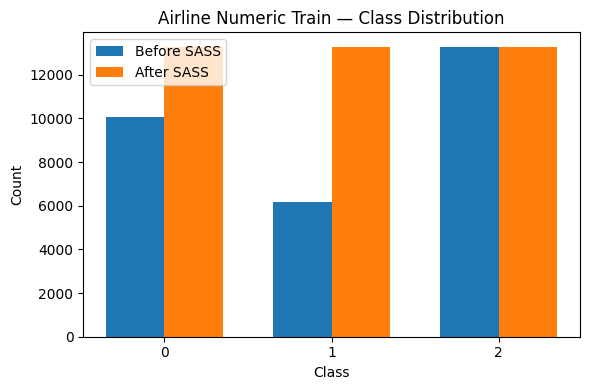


Saving numeric SASS-balanced CSV to: /content/drive/MyDrive/PR_Sky/SASS/Data/Airline_Dataset_work_SASS/airline_train_proc_sass.csv
Saved: /content/drive/MyDrive/PR_Sky/SASS/Data/Airline_Dataset_work_SASS/airline_train_proc_sass.csv

==== TEXT BoC TRAIN: Loading X_train_boc.npy & y_train.npy ====
Text X_train_boc shape: (29490, 275)
Text y_train shape: (29490,)
Text train class counts BEFORE SASS: {0: 10057, 1: 6151, 2: 13282}

[ SASS ] Original class counts: {np.int32(0): np.int64(10057), np.int32(1): np.int64(6151), np.int32(2): np.int64(13282)}
[ SASS ] Target per class: {np.int32(0): np.int64(13282), np.int32(1): np.int64(13282), np.int32(2): np.int64(13282)}
[ SASS ] Class 0: generating 3225 synthetic samples
[ SASS ] Class 1: generating 7131 synthetic samples
[ SASS ] New class counts: {0: 13282, 1: 13282, 2: 13282}
Text train class counts AFTER SASS: {0: 13282, 1: 13282, 2: 13282}


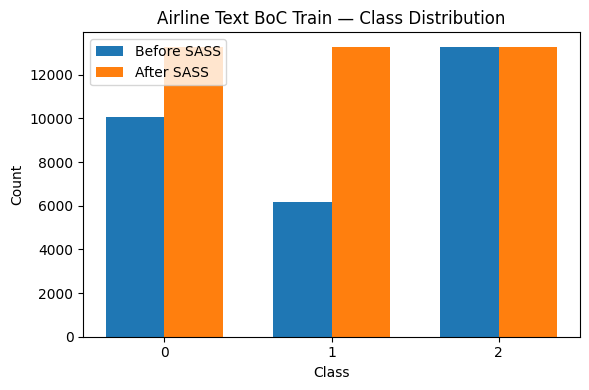


Saved SASS-balanced text arrays:
  X_train_boc_sass.npy -> /content/drive/MyDrive/PR_Sky/SASS/Data/Airline_Dataset_work_SASS/X_train_boc_sass.npy
  y_train_sass.npy     -> /content/drive/MyDrive/PR_Sky/SASS/Data/Airline_Dataset_work_SASS/y_train_sass.npy


In [7]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# ================== PATHS ==================
BASE_DIR = "/content/drive/MyDrive/PR_Sky/SASS/Data/Airline_Dataset_work_SASS"

# Numeric train (from Phase 2)
NUMERIC_TRAIN_CSV      = os.path.join(BASE_DIR, "airline_train_proc.csv")
NUMERIC_TRAIN_SASS_CSV = os.path.join(BASE_DIR, "airline_train_proc_sass.csv")

# Text BoC train (from Phase 2B)
X_TRAIN_BOC_NPY = os.path.join(BASE_DIR, "X_train_boc.npy")
Y_TRAIN_NPY     = os.path.join(BASE_DIR, "y_train.npy")

X_TRAIN_BOC_SASS_NPY = os.path.join(BASE_DIR, "X_train_boc_sass.npy")
Y_TRAIN_SASS_NPY     = os.path.join(BASE_DIR, "y_train_sass.npy")

TARGET_COL = "satisfaction_class"
os.makedirs(BASE_DIR, exist_ok=True)

# ================== UTILS ==================
def compute_class_counts(y):
    classes, counts = np.unique(y, return_counts=True)
    return {int(c): int(n) for c, n in zip(classes, counts)}

def plot_class_distribution(before_counts, after_counts, title_prefix):
    classes = sorted(set(before_counts.keys()) | set(after_counts.keys()))
    before_vals = [before_counts.get(c, 0) for c in classes]
    after_vals  = [after_counts.get(c, 0) for c in classes]

    x = np.arange(len(classes))
    width = 0.35

    plt.figure(figsize=(6, 4))
    plt.bar(x - width/2, before_vals, width, label="Before SASS")
    plt.bar(x + width/2, after_vals,  width, label="After SASS")
    plt.xticks(x, [str(c) for c in classes])
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title(f"{title_prefix} — Class Distribution")
    plt.legend()
    plt.tight_layout()
    plt.show()

def sass_oversample(X, y, smoothing=0.05, random_state=42, target_strategy="max"):
    """
    Smooth Adaptive Synthetic Sampling (SASS).

    - Oversamples minority classes up to max class size
    - Each synthetic point:
        * interpolation between two same-class neighbors
        * + Gaussian noise scaled by feature std
        * clipped to [min, max] per feature
    """
    rng = np.random.RandomState(random_state)
    X = np.asarray(X, dtype=np.float32)
    y = np.asarray(y)

    classes, counts = np.unique(y, return_counts=True)

    if target_strategy == "max":
        target_n = counts.max()
        target_per_class = {c: target_n for c in classes}
    else:
        raise ValueError("Only 'max' target_strategy implemented.")

    print("\n[ SASS ] Original class counts:", dict(zip(classes, counts)))
    print("[ SASS ] Target per class:", target_per_class)

    # Global stats for smoothing/clipping
    feat_std = X.std(axis=0)
    feat_std[feat_std == 0] = 1.0
    feat_min = X.min(axis=0)
    feat_max = X.max(axis=0)

    X_res_parts = [X]
    y_res_parts = [y]

    for c, n_c in zip(classes, counts):
        n_target = target_per_class[c]
        if n_c >= n_target:
            continue

        n_syn = int(n_target - n_c)
        print(f"[ SASS ] Class {c}: generating {n_syn} synthetic samples")

        idx_c = np.where(y == c)[0]
        X_c = X[idx_c]

        k = min(5, len(X_c))
        nn = NearestNeighbors(n_neighbors=k)
        nn.fit(X_c)

        synthetic_samples = []
        for _ in range(n_syn):
            i = rng.choice(len(X_c))
            x_i = X_c[i].reshape(1, -1)

            neigh_idx = nn.kneighbors(x_i, return_distance=False)[0]
            j = rng.choice(neigh_idx)
            x_j = X_c[j]

            lam = rng.rand()
            x_new = x_i.flatten() + lam * (x_j - x_i.flatten())

            noise = rng.normal(loc=0.0, scale=smoothing * feat_std)
            x_new = x_new + noise

            x_new = np.clip(x_new, feat_min, feat_max)
            synthetic_samples.append(x_new)

        X_syn = np.vstack(synthetic_samples)
        y_syn = np.full(n_syn, c, dtype=y.dtype)

        X_res_parts.append(X_syn)
        y_res_parts.append(y_syn)

    X_res = np.vstack(X_res_parts)
    y_res = np.concatenate(y_res_parts)

    perm = rng.permutation(len(y_res))
    X_res = X_res[perm]
    y_res = y_res[perm]

    new_counts = compute_class_counts(y_res)
    print("[ SASS ] New class counts:", new_counts)

    return X_res, y_res

# =========================================================
# PART 1 — NUMERIC TRAIN SET
# =========================================================
print("==== NUMERIC TRAIN: Loading airline_train_proc.csv ====")
with open(NUMERIC_TRAIN_CSV, "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    num_header = reader.fieldnames
    num_rows = [row for row in reader]

if TARGET_COL not in num_header:
    raise ValueError(f"Target column '{TARGET_COL}' not found in numeric train CSV!")

feature_cols = [c for c in num_header if c != TARGET_COL]
print("Numeric feature columns:", feature_cols)

X_num = []
y_num = []
for row in num_rows:
    feat_vec = []
    for c in feature_cols:
        try:
            feat_vec.append(float(row[c]))
        except:
            feat_vec.append(0.0)
    X_num.append(feat_vec)
    y_num.append(int(row[TARGET_COL]))

X_num = np.array(X_num, dtype=np.float32)
y_num = np.array(y_num, dtype=int)

print("Numeric X_train shape:", X_num.shape)
print("Numeric y_train shape:", y_num.shape)

num_counts_before = compute_class_counts(y_num)
print("Numeric train class counts BEFORE SASS:", num_counts_before)

# ---- Apply SASS to numeric view ----
X_num_sass, y_num_sass = sass_oversample(
    X_num, y_num,
    smoothing=0.05,
    random_state=42,
    target_strategy="max"
)

num_counts_after = compute_class_counts(y_num_sass)
print("Numeric train class counts AFTER SASS:", num_counts_after)

# ---- Plot numeric distribution ----
plot_class_distribution(num_counts_before, num_counts_after, title_prefix="Airline Numeric Train")

# ---- Save numeric SASS-balanced CSV ----
print("\nSaving numeric SASS-balanced CSV to:", NUMERIC_TRAIN_SASS_CSV)
out_header = feature_cols + [TARGET_COL]

with open(NUMERIC_TRAIN_SASS_CSV, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=out_header)
    writer.writeheader()
    for i in range(X_num_sass.shape[0]):
        row_out = {}
        for j, c in enumerate(feature_cols):
            row_out[c] = X_num_sass[i, j]
        row_out[TARGET_COL] = int(y_num_sass[i])
        writer.writerow(row_out)

print("Saved:", NUMERIC_TRAIN_SASS_CSV)

# =========================================================
# PART 2 — TEXT BoC TRAIN SET
# =========================================================
print("\n==== TEXT BoC TRAIN: Loading X_train_boc.npy & y_train.npy ====")
X_text = np.load(X_TRAIN_BOC_NPY)
y_text = np.load(Y_TRAIN_NPY)

print("Text X_train_boc shape:", X_text.shape)
print("Text y_train shape:", y_text.shape)

text_counts_before = compute_class_counts(y_text)
print("Text train class counts BEFORE SASS:", text_counts_before)

# ---- Apply SASS to BoC text view ----
X_text_sass, y_text_sass = sass_oversample(
    X_text, y_text,
    smoothing=0.02,   # smaller noise for sparse text features
    random_state=42,
    target_strategy="max"
)

text_counts_after = compute_class_counts(y_text_sass)
print("Text train class counts AFTER SASS:", text_counts_after)

# ---- Plot text distribution ----
plot_class_distribution(text_counts_before, text_counts_after, title_prefix="Airline Text BoC Train")

# ---- Save SASS-balanced BoC arrays ----
np.save(X_TRAIN_BOC_SASS_NPY, X_text_sass)
np.save(Y_TRAIN_SASS_NPY,     y_text_sass)

print("\nSaved SASS-balanced text arrays:")
print("  X_train_boc_sass.npy ->", X_TRAIN_BOC_SASS_NPY)
print("  y_train_sass.npy     ->", Y_TRAIN_SASS_NPY)


Gaussian Naive Bayes (GNB)

Airline GNB — X_train: (39846, 6) X_test: (7371, 6)

=== Airline — GaussianNB (SASS numeric) ===
Accuracy          : 0.9569
Macro Precision   : 0.9443
Macro Recall      : 0.9537
Macro F1          : 0.9483
Weighted Precision: 0.9590
Weighted Recall   : 0.9569
Weighted F1       : 0.9574
Log-Loss          : 0.1981
Brier Score       : 0.075029

Classification Report:
              precision    recall  f1-score   support

           0     0.9802    0.9459    0.9628      2514
           1     0.8673    0.9440    0.9040      1537
           2     0.9853    0.9711    0.9782      3320

    accuracy                         0.9569      7371
   macro avg     0.9443    0.9537    0.9483      7371
weighted avg     0.9590    0.9569    0.9574      7371



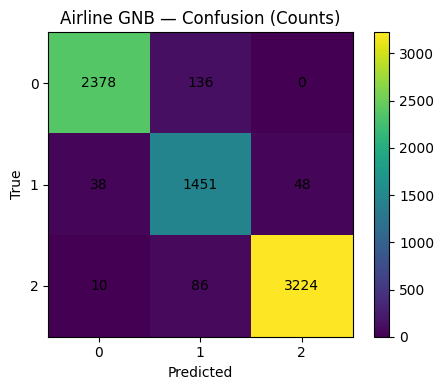

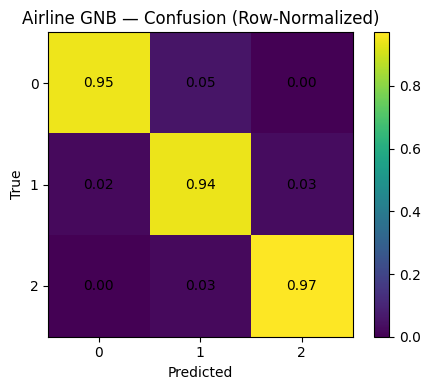

In [8]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    log_loss,
    confusion_matrix,
    classification_report,
)

BASE_DIR = "/content/drive/MyDrive/PR_Sky/SASS/Data/Airline_Dataset_work_SASS"
TRAIN_CSV = os.path.join(BASE_DIR, "airline_train_proc_sass.csv")
TEST_CSV  = os.path.join(BASE_DIR, "airline_test_proc.csv")
TARGET_COL = "satisfaction_class"

def load_numeric_csv(path, target_col):
    with open(path, "r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        header = reader.fieldnames
        rows = [r for r in reader]

    if target_col not in header:
        raise ValueError(f"{target_col} not in {path}")

    features = [c for c in header if c != target_col]
    X, y = [], []
    for row in rows:
        vec = []
        for c in features:
            try:
                vec.append(float(row[c]))
            except:
                vec.append(0.0)
        X.append(vec)
        y.append(int(float(row[target_col])))
    return np.array(X, dtype=np.float32), np.array(y, dtype=int), features

X_train, y_train, feat_cols = load_numeric_csv(TRAIN_CSV, TARGET_COL)
X_test,  y_test,  _         = load_numeric_csv(TEST_CSV,  TARGET_COL)

print("Airline GNB — X_train:", X_train.shape, "X_test:", X_test.shape)

gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred  = gnb.predict(X_test)
y_proba = gnb.predict_proba(X_test)
classes = gnb.classes_

acc = accuracy_score(y_test, y_pred)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred, average="macro")
prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")
ll = log_loss(y_test, y_proba, labels=classes)

Y_true_oh = np.zeros_like(y_proba)
for i, yi in enumerate(y_test):
    ci = np.where(classes == yi)[0][0]
    Y_true_oh[i, ci] = 1.0
brier = np.mean(np.sum((y_proba - Y_true_oh) ** 2, axis=1))

print("\n=== Airline — GaussianNB (SASS numeric) ===")
print(f"Accuracy          : {acc:.4f}")
print(f"Macro Precision   : {prec_macro:.4f}")
print(f"Macro Recall      : {rec_macro:.4f}")
print(f"Macro F1          : {f1_macro:.4f}")
print(f"Weighted Precision: {prec_w:.4f}")
print(f"Weighted Recall   : {rec_w:.4f}")
print(f"Weighted F1       : {f1_w:.4f}")
print(f"Log-Loss          : {ll:.4f}")
print(f"Brier Score       : {brier:.6f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred, labels=classes)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
ticks = np.arange(len(classes))

plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation="nearest")
plt.title("Airline GNB — Confusion (Counts)")
plt.colorbar()
plt.xticks(ticks, classes)
plt.yticks(ticks, classes)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i,j]), ha="center", va="center")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

plt.figure(figsize=(5,4))
plt.imshow(cm_norm, interpolation="nearest")
plt.title("Airline GNB — Confusion (Row-Normalized)")
plt.colorbar()
plt.xticks(ticks, classes)
plt.yticks(ticks, classes)
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(j, i, f"{cm_norm[i,j]:.2f}", ha="center", va="center")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()


Multinomial Naive Bayes (MNB)

Airline MNB — X_train: (39846, 275) X_test: (7371, 275)

=== Airline — MultinomialNB (SASS BoC) ===
Accuracy          : 0.5804
Macro Precision   : 0.5419
Macro Recall      : 0.5410
Macro F1          : 0.5411
Weighted Precision: 0.5874
Weighted Recall   : 0.5804
Weighted F1       : 0.5836
Log-Loss          : 2.0257
Brier Score       : 0.651980

Classification Report:
              precision    recall  f1-score   support

           0     0.6392    0.6273    0.6332      2514
           1     0.3098    0.3390    0.3237      1537
           2     0.6766    0.6566    0.6665      3320

    accuracy                         0.5804      7371
   macro avg     0.5419    0.5410    0.5411      7371
weighted avg     0.5874    0.5804    0.5836      7371



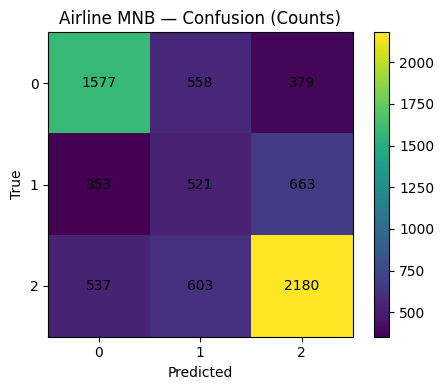

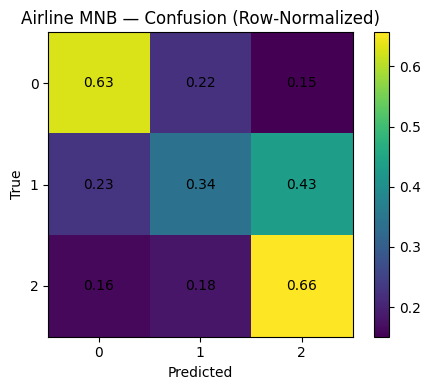

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    log_loss,
    confusion_matrix,
    classification_report,
)

BASE_DIR = "/content/drive/MyDrive/PR_Sky/SASS/Data/Airline_Dataset_work_SASS"

X_TRAIN_SASS = os.path.join(BASE_DIR, "X_train_boc_sass.npy")
Y_TRAIN_SASS = os.path.join(BASE_DIR, "y_train_sass.npy")
X_TEST_FILE  = os.path.join(BASE_DIR, "X_test_boc.npy")
Y_TEST_FILE  = os.path.join(BASE_DIR, "y_test.npy")

X_train = np.load(X_TRAIN_SASS)
y_train = np.load(Y_TRAIN_SASS)
X_test  = np.load(X_TEST_FILE)
y_test  = np.load(Y_TEST_FILE)

print("Airline MNB — X_train:", X_train.shape, "X_test:", X_test.shape)

mnb = MultinomialNB()
mnb.fit(X_train, y_train)

y_pred  = mnb.predict(X_test)
y_proba = mnb.predict_proba(X_test)
classes = mnb.classes_

acc = accuracy_score(y_test, y_pred)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred, average="macro")
prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")
ll = log_loss(y_test, y_proba, labels=classes)

Y_true_oh = np.zeros_like(y_proba)
for i, yi in enumerate(y_test):
    ci = np.where(classes == yi)[0][0]
    Y_true_oh[i, ci] = 1.0
brier = np.mean(np.sum((y_proba - Y_true_oh) ** 2, axis=1))

print("\n=== Airline — MultinomialNB (SASS BoC) ===")
print(f"Accuracy          : {acc:.4f}")
print(f"Macro Precision   : {prec_macro:.4f}")
print(f"Macro Recall      : {rec_macro:.4f}")
print(f"Macro F1          : {f1_macro:.4f}")
print(f"Weighted Precision: {prec_w:.4f}")
print(f"Weighted Recall   : {rec_w:.4f}")
print(f"Weighted F1       : {f1_w:.4f}")
print(f"Log-Loss          : {ll:.4f}")
print(f"Brier Score       : {brier:.6f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred, labels=classes)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
ticks = np.arange(len(classes))

plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation="nearest")
plt.title("Airline MNB — Confusion (Counts)")
plt.colorbar()
plt.xticks(ticks, classes)
plt.yticks(ticks, classes)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i,j]), ha="center", va="center")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

plt.figure(figsize=(5,4))
plt.imshow(cm_norm, interpolation="nearest")
plt.title("Airline MNB — Confusion (Row-Normalized)")
plt.colorbar()
plt.xticks(ticks, classes)
plt.yticks(ticks, classes)
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(j, i, f"{cm_norm[i,j]:.2f}", ha="center", va="center")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()


BernoulliNB (BNB)

Airline BNB — rows after cleaning: 36861
BNB — X_all shape: (36861, 3083) num features: 3083

=== Airline — BernoulliNB (categorical) ===
Accuracy          : 0.5317
Macro Precision   : 0.4627
Macro Recall      : 0.4378
Macro F1          : 0.4061
Weighted Precision: 0.4925
Weighted Recall   : 0.5317
Weighted F1       : 0.4761
Log-Loss          : 1.0026
Brier Score       : 0.593503

Classification Report:
              precision    recall  f1-score   support

           0     0.5721    0.4594    0.5096      2514
           1     0.2905    0.0397    0.0698      1537
           2     0.5257    0.8142    0.6389      3320

    accuracy                         0.5317      7371
   macro avg     0.4627    0.4378    0.4061      7371
weighted avg     0.4925    0.5317    0.4761      7371



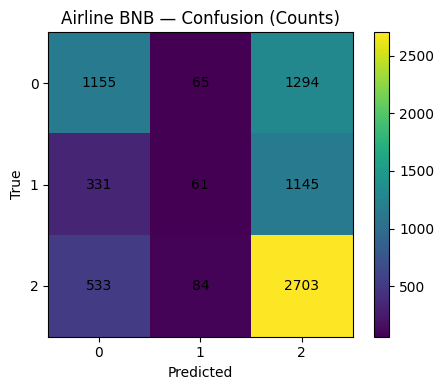

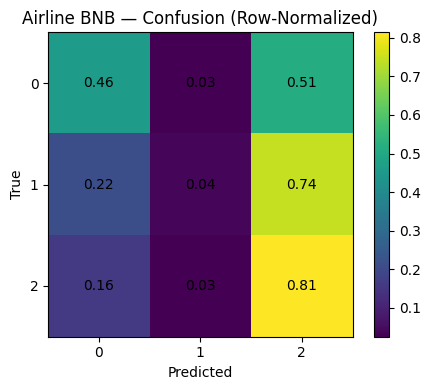

In [10]:
import os
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    log_loss,
    confusion_matrix,
    classification_report,
)

BASE_DIR   = "/content/drive/MyDrive/PR_Sky/SASS/Data/Airline_Dataset_work_SASS"
INPUT_CSV  = os.path.join(BASE_DIR, "airline_with_target.csv")
TARGET_COL = "satisfaction_class"

categorical_cols = [
    "airline_name",
    "type_traveller",
    "cabin_flown",
    "route",
    "author_country",
    "aircraft",
]

rows = []
with open(INPUT_CSV, "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    header = reader.fieldnames
    for row in reader:
        rows.append(row)

clean_rows = []
for row in rows:
    v = row.get(TARGET_COL, "")
    try:
        vv = int(float(v))
    except:
        continue
    if vv not in (0,1,2):
        continue
    # at least one categorical non-empty
    if not any(str(row.get(c, "")).strip() != "" for c in categorical_cols):
        continue
    row[TARGET_COL] = vv
    clean_rows.append(row)

rows = clean_rows
print("Airline BNB — rows after cleaning:", len(rows))

vec_dicts = []
labels = []
for r in rows:
    d = {}
    for c in categorical_cols:
        v = str(r.get(c, "")).strip() or "MISSING"
        d[f"{c}={v}"] = 1
    vec_dicts.append(d)
    labels.append(r[TARGET_COL])

labels = np.array(labels, dtype=int)

from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)
X_all = dv.fit_transform(vec_dicts)

print("BNB — X_all shape:", X_all.shape, "num features:", len(dv.feature_names_))

idx0 = [i for i,y in enumerate(labels) if y==0]
idx1 = [i for i,y in enumerate(labels) if y==1]
idx2 = [i for i,y in enumerate(labels) if y==2]

random.seed(42)
random.shuffle(idx0); random.shuffle(idx1); random.shuffle(idx2)

def split_ids(lst):
    n = int(len(lst)*0.2)
    return lst[n:], lst[:n]

tr0, te0 = split_ids(idx0)
tr1, te1 = split_ids(idx1)
tr2, te2 = split_ids(idx2)

train_idx = tr0+tr1+tr2
test_idx  = te0+te1+te2

X_train = X_all[train_idx]
y_train = labels[train_idx]
X_test  = X_all[test_idx]
y_test  = labels[test_idx]

bnb = BernoulliNB()
bnb.fit(X_train, y_train)

y_pred  = bnb.predict(X_test)
y_proba = bnb.predict_proba(X_test)
classes = bnb.classes_

acc = accuracy_score(y_test, y_pred)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred, average="macro")
prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")
ll = log_loss(y_test, y_proba, labels=classes)

Y_true_oh = np.zeros_like(y_proba)
for i, yi in enumerate(y_test):
    ci = np.where(classes == yi)[0][0]
    Y_true_oh[i, ci] = 1.0
brier = np.mean(np.sum((y_proba - Y_true_oh)**2, axis=1))

print("\n=== Airline — BernoulliNB (categorical) ===")
print(f"Accuracy          : {acc:.4f}")
print(f"Macro Precision   : {prec_macro:.4f}")
print(f"Macro Recall      : {rec_macro:.4f}")
print(f"Macro F1          : {f1_macro:.4f}")
print(f"Weighted Precision: {prec_w:.4f}")
print(f"Weighted Recall   : {rec_w:.4f}")
print(f"Weighted F1       : {f1_w:.4f}")
print(f"Log-Loss          : {ll:.4f}")
print(f"Brier Score       : {brier:.6f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred, labels=classes)
cm_norm = cm.astype(float)/cm.sum(axis=1, keepdims=True)
ticks = np.arange(len(classes))

plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation="nearest")
plt.title("Airline BNB — Confusion (Counts)")
plt.colorbar()
plt.xticks(ticks, classes); plt.yticks(ticks, classes)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j,i,str(cm[i,j]),ha="center",va="center")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

plt.figure(figsize=(5,4))
plt.imshow(cm_norm, interpolation="nearest")
plt.title("Airline BNB — Confusion (Row-Normalized)")
plt.colorbar()
plt.xticks(ticks, classes); plt.yticks(ticks, classes)
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(j,i,f"{cm_norm[i,j]:.2f}",ha="center",va="center")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()


Hybrid GNB + MNB

Hybrid Airline — num train: (39846, 6) text train: (39846, 275)
alpha=0.1 -> LogLoss=0.8342, Acc=0.6020, MacroF1=0.5634
alpha=0.2 -> LogLoss=0.6497, Acc=0.6302, MacroF1=0.5934
alpha=0.3 -> LogLoss=0.5283, Acc=0.6688, MacroF1=0.6360
alpha=0.4 -> LogLoss=0.4361, Acc=0.7489, MacroF1=0.7223
alpha=0.5 -> LogLoss=0.3615, Acc=0.9124, MacroF1=0.8982
alpha=0.6 -> LogLoss=0.2990, Acc=0.9546, MacroF1=0.9453
alpha=0.7 -> LogLoss=0.2459, Acc=0.9582, MacroF1=0.9497
alpha=0.8 -> LogLoss=0.2008, Acc=0.9565, MacroF1=0.9477
alpha=0.9 -> LogLoss=0.1641, Acc=0.9565, MacroF1=0.9478

=== Airline — Hybrid (GNB + MNB) ===
Best alpha        : 0.90
Best Log-Loss     : 0.1641
Accuracy          : 0.9565
Macro Precision   : 0.9438
Macro Recall      : 0.9532
Macro F1          : 0.9478
Weighted Precision: 0.9586
Weighted Recall   : 0.9565
Weighted F1       : 0.9571
Brier Score       : 0.076149

Classification Report (Hybrid):
              precision    recall  f1-score   support

           0     0.9798    0.9455   

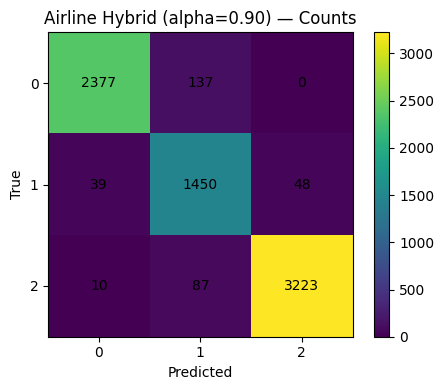

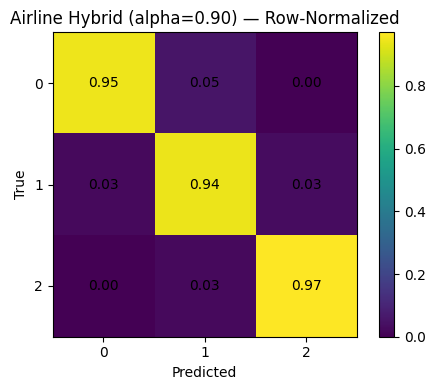

In [11]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    log_loss,
    confusion_matrix,
    classification_report,
)

BASE_DIR = "/content/drive/MyDrive/PR_Sky/SASS/Data/Airline_Dataset_work_SASS"

NUM_TRAIN_CSV = os.path.join(BASE_DIR, "airline_train_proc_sass.csv")
NUM_TEST_CSV  = os.path.join(BASE_DIR, "airline_test_proc.csv")
X_TRAIN_SASS  = os.path.join(BASE_DIR, "X_train_boc_sass.npy")
Y_TRAIN_SASS  = os.path.join(BASE_DIR, "y_train_sass.npy")
X_TEST_BOC    = os.path.join(BASE_DIR, "X_test_boc.npy")
Y_TEST        = os.path.join(BASE_DIR, "y_test.npy")

TARGET_COL = "satisfaction_class"

def load_numeric_csv(path, target_col):
    with open(path, "r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        header = reader.fieldnames
        rows = [r for r in reader]
    feats = [c for c in header if c != target_col]
    X, y = [], []
    for r in rows:
        vec = []
        for c in feats:
            try: vec.append(float(r[c]))
            except: vec.append(0.0)
        X.append(vec)
        y.append(int(float(r[target_col])))
    return np.array(X, dtype=np.float32), np.array(y, dtype=int), feats

X_train_num, y_train_num, _ = load_numeric_csv(NUM_TRAIN_CSV, TARGET_COL)
X_test_num,  y_test_num,  _ = load_numeric_csv(NUM_TEST_CSV,  TARGET_COL)

X_train_text = np.load(X_TRAIN_SASS)
y_train_text = np.load(Y_TRAIN_SASS)
X_test_text  = np.load(X_TEST_BOC)
y_test_text  = np.load(Y_TEST)

print("Hybrid Airline — num train:", X_train_num.shape, "text train:", X_train_text.shape)

if not np.array_equal(y_test_num, y_test_text):
    print("WARNING: y_test mismatch between numeric and text views.")
y_test = y_test_num

gnb = GaussianNB().fit(X_train_num, y_train_num)
mnb = MultinomialNB().fit(X_train_text, y_train_text)

P_gnb = gnb.predict_proba(X_test_num)
P_mnb = mnb.predict_proba(X_test_text)

classes_g = gnb.classes_
classes_m = mnb.classes_
if not np.array_equal(classes_g, classes_m):
    raise ValueError("Class mismatch between GNB and MNB.")
classes = classes_g

alphas = [i/10 for i in range(1,10)]
best_alpha, best_ll, best_P, best_y_pred, best_metrics = None, None, None, None, None

for a in alphas:
    P_h = a*P_gnb + (1-a)*P_mnb
    eps = 1e-15
    P_h = np.clip(P_h, eps, 1-eps)
    P_h = P_h / P_h.sum(axis=1, keepdims=True)
    ll = log_loss(y_test, P_h, labels=classes)
    y_pred = classes[np.argmax(P_h, axis=1)]
    acc = accuracy_score(y_test, y_pred)
    _, _, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred, average="macro")
    print(f"alpha={a:.1f} -> LogLoss={ll:.4f}, Acc={acc:.4f}, MacroF1={f1_macro:.4f}")
    if best_ll is None or ll < best_ll:
        best_ll = ll
        best_alpha = a
        best_P = P_h
        best_y_pred = y_pred
        prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred, average="macro")
        prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")
        best_metrics = (acc, prec_macro, rec_macro, f1_macro, prec_w, rec_w, f1_w)

acc, prec_macro, rec_macro, f1_macro, prec_w, rec_w, f1_w = best_metrics

Y_true_oh = np.zeros_like(best_P)
for i, yi in enumerate(y_test):
    ci = np.where(classes == yi)[0][0]
    Y_true_oh[i, ci] = 1.0
brier = np.mean(np.sum((best_P - Y_true_oh)**2, axis=1))

print("\n=== Airline — Hybrid (GNB + MNB) ===")
print(f"Best alpha        : {best_alpha:.2f}")
print(f"Best Log-Loss     : {best_ll:.4f}")
print(f"Accuracy          : {acc:.4f}")
print(f"Macro Precision   : {prec_macro:.4f}")
print(f"Macro Recall      : {rec_macro:.4f}")
print(f"Macro F1          : {f1_macro:.4f}")
print(f"Weighted Precision: {prec_w:.4f}")
print(f"Weighted Recall   : {rec_w:.4f}")
print(f"Weighted F1       : {f1_w:.4f}")
print(f"Brier Score       : {brier:.6f}")
print("\nClassification Report (Hybrid):")
print(classification_report(y_test, best_y_pred, digits=4))

cm = confusion_matrix(y_test, best_y_pred, labels=classes)
cm_norm = cm.astype(float)/cm.sum(axis=1, keepdims=True)
ticks = np.arange(len(classes))

plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation="nearest")
plt.title(f"Airline Hybrid (alpha={best_alpha:.2f}) — Counts")
plt.colorbar()
plt.xticks(ticks, classes); plt.yticks(ticks, classes)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j,i,str(cm[i,j]),ha="center",va="center")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

plt.figure(figsize=(5,4))
plt.imshow(cm_norm, interpolation="nearest")
plt.title(f"Airline Hybrid (alpha={best_alpha:.2f}) — Row-Normalized")
plt.colorbar()
plt.xticks(ticks, classes); plt.yticks(ticks, classes)
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(j,i,f"{cm_norm[i,j]:.2f}",ha="center",va="center")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()
